<a href="https://colab.research.google.com/github/Div-ex/Advertising_Location/blob/main/Voronoi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import csv
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
with open('/content/drive/MyDrive/world_country_and_usa_states_latitude_and_longitude_values.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
# print(data)


with open("/content/drive/MyDrive/world_country_and_usa_states_latitude_and_longitude_values.csv", "r") as source:
    reader = csv.reader(source)

    with open("/content/drive/MyDrive/world_country_and_usa_states_latitude_and_longitude_values_numeric.csv", "w") as result:
        writer = csv.writer(result)
        for r in reader:
            # Use CSV Index to remove a column from CSV
            #r[3] = r['year']
            writer.writerow((r[1], r[2]))

with open('/content/drive/MyDrive/world_country_and_usa_states_latitude_and_longitude_values_numeric.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)

for row in data:
    first_val = row[0]
    try:
        float(first_val)
    except ValueError:
        data.pop(data.index(row))

data.pop(0)
# print(data)
data_array = np.array(data, dtype=float)

--
[[10, 5, 6, 4, 9], [10, 12, 11, 5], [8, 2, 3, 1, 7], [13, 14, 7, 8], [1, 7, 16, 15, 9, 4], [9, 17, 18, 10], [19, 20, 8, 2], [6, 0, 3, 1, 4], [21, 0, 6, 5, 22], [23, 24, 2, 3, 0]]
--
[[ -35.30686736  -19.36580874]
 [  16.55941869  -17.12582212]
 [ -11.15168138  -48.25885789]
 [ -11.84258769  -27.20159921]
 [  14.59523863   27.69403782]
 [ -96.19126117  155.50039177]
 [ -71.78945098  110.8437666 ]
 [  54.95890456  -28.41287084]
 [  14.47642837  -65.31708852]
 [  22.41401795   31.80993009]
 [  35.14957065   55.87264235]
 [-171.59011844  276.9616559 ]
 [ 173.15500426   93.18653596]
 [ 115.53973832 -166.43105266]
 [ 192.78454307  -66.38548904]
 [ 165.23927906   38.03657849]
 [ 192.78454307  -66.38548904]
 [ 165.23927906   38.03657849]
 [ 173.15500426   93.18653596]
 [ -26.43022595 -190.40101363]
 [ 115.53973832 -166.43105266]
 [-158.99059059  -91.06073861]
 [-171.59011844  276.9616559 ]
 [-158.99059059  -91.06073861]
 [ -26.43022595 -190.40101363]]


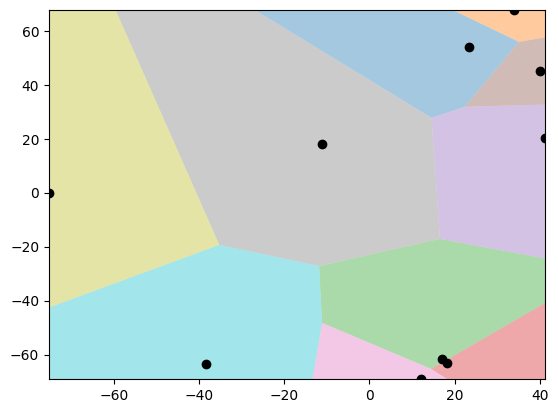

In [ ]:


def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# # make up data points
# np.random.seed(1234)
# points = np.random.rand(14, 2)

points = data_array[:10]
# points.sort(axis = 1)
# points = points[0:10]

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)
print ("--")
print (regions)
print ("--")
print (vertices)

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:,0], points[:,1], 'ko')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.show()
# print(points)